# ⚠️ Suppress warnings

In [ ]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# ⚙️ Import Libraries

In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
from keras.utils import to_categorical
from keras import applications as pretrained
!pip install keras_cv
import keras_cv

import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 1


## 👀 View

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

TEXT_LABELS = ['Basophil',               # 0
               'Eosinophil',             # 1
               'Erythroblast',           # 2
               'Immature granulocytes',  # 3
               'Lymphocyte',             # 4
               'Monocyte',               # 5
               'Neutrophil',             # 6
               'Platelet']               # 7

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

## 📝 Logging

In [ ]:
import logging

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## 🎲 Reproducibility

In [ ]:
import random

seed = 12

np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## 📁 System

In [ ]:
import os
import gc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

BASE_DIR = '/kaggle/input/hw1-dataset-2'
MODEL_FILENAME = 'convnext.keras'
FT_MODEL_FILENAME = 'convnext_ft.keras'
TRAINSET_FILENAME = os.path.join(BASE_DIR, 'train_set.npz')
VALIDSET_FILENAME = os.path.join(BASE_DIR, 'valid_set.npz')
TESTSET_FILENAME = os.path.join(BASE_DIR, 'test_set_noisy.npz')

# ⏳ Load Data

In [ ]:
def load_from_file(filename):
    data = np.load(filename)
    print("Keys: ", data.keys())
    X = data["images"]
    y = data["labels"]
    print("Data shape: ", X.shape)
    print("Label shape: ", y.shape)
    X, y = shuffle(X, y, random_state=seed)
    return X, y

X_train, y_train = load_from_file(TRAINSET_FILENAME)
X_valid, y_valid = load_from_file(VALIDSET_FILENAME)
X_test, y_test = load_from_file(TESTSET_FILENAME)

Keys:  KeysView(NpzFile '/kaggle/input/hw1-dataset-2/train_set.npz' with keys: images, labels)
Data shape:  (14911, 96, 96, 3)
Label shape:  (14911, 8)
Keys:  KeysView(NpzFile '/kaggle/input/hw1-dataset-2/valid_set.npz' with keys: images, labels)
Data shape:  (1865, 96, 96, 3)
Label shape:  (1865, 8)
Keys:  KeysView(NpzFile '/kaggle/input/hw1-dataset-2/test_set_noisy.npz' with keys: images, labels)
Data shape:  (1864, 96, 96, 3)
Label shape:  (1864, 8)


## 🔎 Inspect Data

In [ ]:
def take_of_class(images, labels, n=4, targets=[0,1,2,3,4,5,6,7]):
    X = []

    for target_label in targets:
        target_indices = np.where(labels == target_label)[0]
        X.append(images[target_indices[:n]])

    return X, targets

def plot_samples(images, labels, categories):
    num_labels = len(labels)

    for i, label in enumerate(labels):
        title = f"{label}: {categories[label]}"
        num_images = images[i].shape[0]
        plt.figure(figsize=(6, (num_images+3)//4*2)).suptitle(title, fontsize=18)
        for j, img in enumerate(images[i]):
            plt.subplot((num_images+3)//4, 4, j+1)
            plt.imshow(img.astype("uint8"))
            plt.axis("off")
        plt.show()

def plot_all(images, title):
    num_images = images.shape[0]
    plt.figure(figsize=(6, (num_images+3)//4*2)).suptitle(title)
    for i in range(num_images):
        plt.subplot((num_images+3)//4, 4, i+1)
        plt.imshow(images[i].astype("uint8"))
        plt.axis("off")
    plt.show()

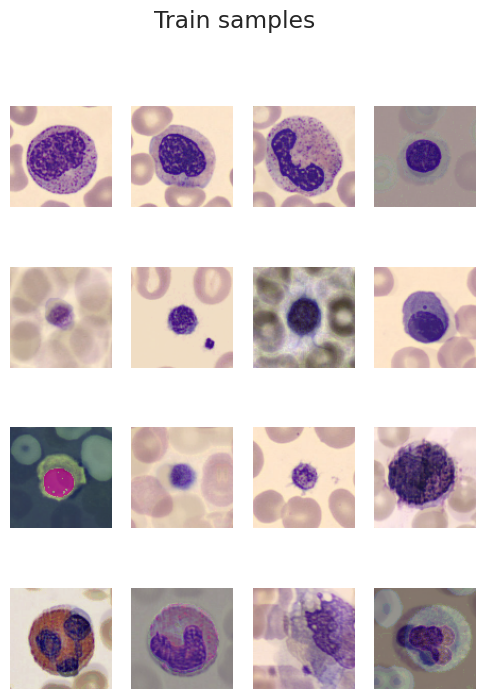

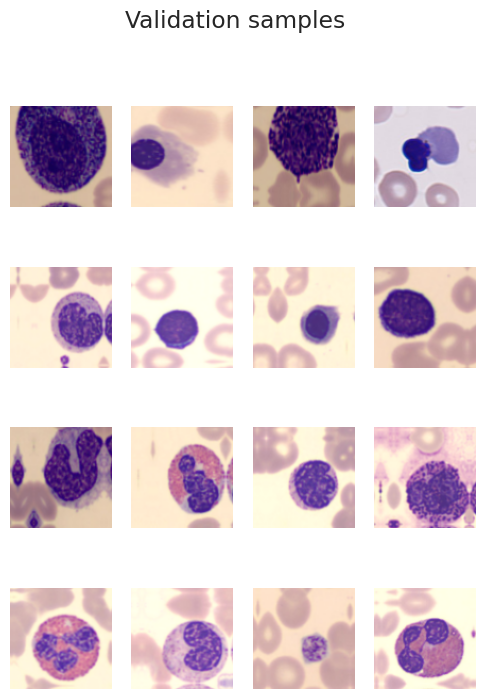

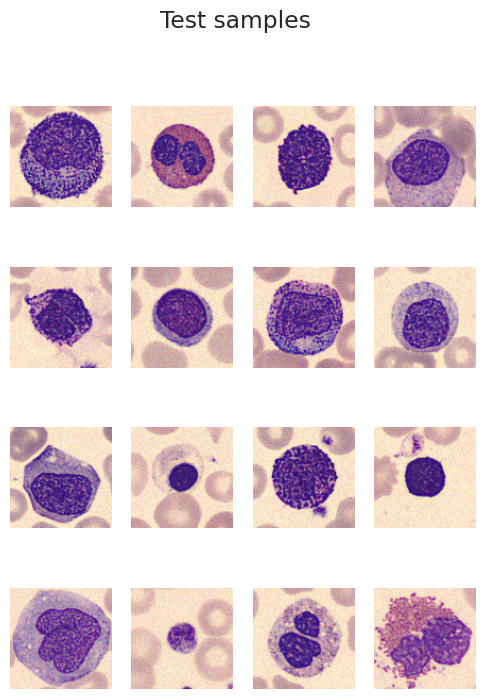

In [ ]:
plot_all(X_train[:16], 'Train samples')
plot_all(X_valid[:16], 'Validation samples')
plot_all(X_test[:16], 'Test samples')

# 🛠️ Transfer learning

In [ ]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [ ]:
fen = pretrained.ConvNeXtBase(
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_shape=input_shape,
    pooling="avg",
    classes=8,
    classifier_activation="softmax"
)

fen.trainable = False

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
inputs = tfkl.Input(shape=input_shape, name='input')
x = fen(inputs)
x = tfkl.Dropout(0.3)(x)
x = tfkl.Dense(units=2**output_shape, activation='swish', kernel_initializer=tfk.initializers.HeUniform(),
               kernel_regularizer=tfk.regularizers.L2(1e-2), name='fc_1')(x)
x = tfkl.Dropout(0.5)(x)
outputs = tfkl.Dense(units=output_shape, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(), name='output')(x)

model = tfk.Model(inputs=inputs, outputs=outputs, name='HW1-ConvNeXt')

model.summary(expand_nested=True, show_trainable=True)

Model: "HW1-ConvNeXt"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ convnext_base (Functional)  │ (None, 1024)          │ 87,566,464 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer            │ (None, 96, 96, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 96, 96, 3)     │          0 │   -   │
│ convnext_base_prestem_norm… │                       │            │       │
│ (Normalization)             │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ convnext_base_stem     │ (None, 24, 24, 128)   │      6,528 │   N   │
│ (Sequential)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └                     │ (None, 24, 24, 128)   │      6,272 │   N   │
│ convnext_base_stem_conv     │                       │            │       │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └                     │ (None, 24, 24, 128)   │        256 │   N   │
│ convnext_base_stem_layerno… │                       │            │       │
│ (LayerNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │      6,400 │   N   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │        256 │   N   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (LayerNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 512)   │     66,048 │   N   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (Dense)                     │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 512)   │          0 │   -   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │     65,664 │   N   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (Dense)                     │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │        128 │   N   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (LayerScale)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │          0 │   -   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (Activation)                │                       │            │     

 Total params: 87,830,920 (335.05 MB)

 Trainable params: 264,456 (1.01 MB)

 Non-trainable params: 87,566,464 (334.04 MB)

## 🧠 Train the classifier

In [ ]:
# Number of training epochs
epochs = 100

# Batch size for training
batch_size = 32

# Define the patience value for early stopping
patience = 10

# Learning rate: step size for updating the model's weights
learning_rate = 1e-4

# Cosine Decay with restarts
steps_per_epoch = X_train.shape[0]//batch_size
epochs_per_decay_cycle = 7
decay = tfk.optimizers.schedules.CosineDecayRestarts(learning_rate, epochs_per_decay_cycle*steps_per_epoch)

# Class weights
class_weights = {0: 1.,
                 7: 1.,
                 2: 1.,
                 3: 1.,
                 4: 1.,
                 5: 1.,
                 6: 1.,
                 7: 1.}

# Optimization
loss = tfk.losses.CategoricalCrossentropy()
optimizer = tfk.optimizers.Nadam(decay)
metrics = ['accuracy']

# Compile the model with categorical crossentropy loss and Nadam optimizer
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(X_train.shape[0], seed=seed, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.shuffle(X_train.shape[0], seed=seed, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Train the model with early stopping callback
tl_history = model.fit(
    train_ds,
    validation_data=valid_ds,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(tl_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file
model.save(MODEL_FILENAME)

Epoch 1/100


I0000 00:00:1732379986.630721      78 service.cc:145] XLA service 0x7f1b14004d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732379986.630771      78 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/466 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.0859 - loss: 8.9237   

I0000 00:00:1732379995.633119      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


466/466 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - accuracy: 0.3548 - loss: 6.9259 - val_accuracy: 0.7689 - val_loss: 4.8504
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.6673 - loss: 4.8133 - val_accuracy: 0.8155 - val_loss: 3.8590
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.7304 - loss: 3.8857 - val_accuracy: 0.8300 - val_loss: 3.2394
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.7558 - loss: 3.3009 - val_accuracy: 0.8429 - val_loss: 2.8718
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.7639 - loss: 2.9866 - val_accuracy: 0.8440 - val_loss: 2.6879
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.7752 - loss: 2.8057 - val_accuracy: 0.8509 - val_loss: 2.6120
Epoch 7/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.7775 - loss: 2.7486 - val_accuracy: 0.8509 - val_loss: 2.5933
Epoch 8/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.7820 - loss: 2.5966 - val_

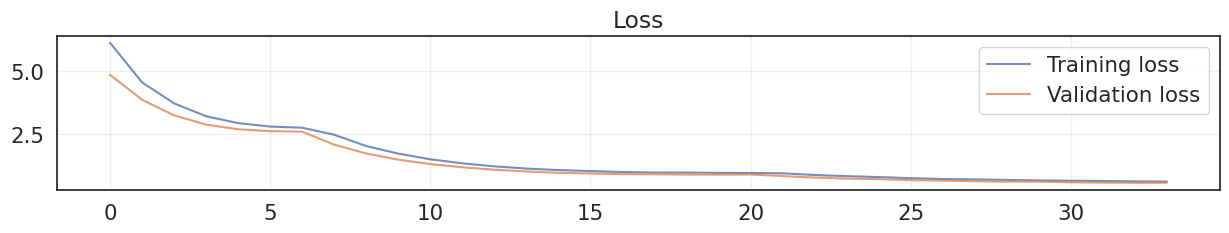

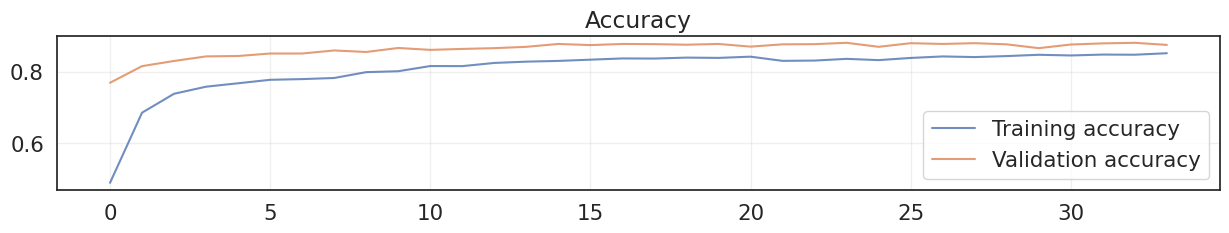

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(tl_history['loss'], label='Training loss', alpha=.8)
plt.plot(tl_history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(tl_history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# 🛠️ Fine tuning

In [ ]:
del model
gc.collect()

fen_layer = 'convnext_base'

# Re-load the model after transfer learning
model = tfk.models.load_model(MODEL_FILENAME)

In [ ]:
# Set the model layers as trainable
model.get_layer(fen_layer).trainable = True

# Set all layers as non-trainable
for layer in model.get_layer(fen_layer).layers:
    layer.trainable = False

# Only train third stage blocks
N = 36
for i, layer in enumerate(model.get_layer(fen_layer).layers[-N:]):
    # Only convolution and dense, I do not really want to train normalization
    if isinstance(layer, tfkl.Conv2D) or isinstance(layer, tfkl.Dense):
        layer.trainable = True

model.summary(expand_nested=True, show_trainable=True)

Model: "HW1-ConvNeXt"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ convnext_base (Functional)  │ (None, 1024)          │ 87,566,464 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer            │ (None, 96, 96, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 96, 96, 3)     │          0 │   -   │
│ convnext_base_prestem_norm… │                       │            │       │
│ (Normalization)             │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ convnext_base_stem     │ (None, 24, 24, 128)   │      6,528 │   N   │
│ (Sequential)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └                     │ (None, 24, 24, 128)   │      6,272 │   N   │
│ convnext_base_stem_conv     │                       │            │       │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └                     │ (None, 24, 24, 128)   │        256 │   N   │
│ convnext_base_stem_layerno… │                       │            │       │
│ (LayerNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │      6,400 │   N   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │        256 │   N   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (LayerNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 512)   │     66,048 │   N   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (Dense)                     │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 512)   │          0 │   -   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │     65,664 │   N   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (Dense)                     │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │        128 │   N   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (LayerScale)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 24, 24, 128)   │          0 │   -   │
│ convnext_base_stage_0_bloc… │                       │            │       │
│ (Activation)                │                       │            │     

 Total params: 88,359,834 (337.07 MB)

 Trainable params: 29,824,264 (113.77 MB)

 Non-trainable params: 58,006,656 (221.28 MB)

 Optimizer params: 528,914 (2.02 MB)

## 🧠 Train the entire network

In [ ]:
# Number of training epochs
epochs = 100

# Batch size for training
batch_size = 32

# Learning rate: step size for updating the model's weights
learning_rate = 1e-5

# Cosine Decay with restarts
steps_per_epoch = X_train.shape[0]//batch_size
epochs_per_decay_cycle = 7 # restart every 7 epoch (approximatively)
decay = tfk.optimizers.schedules.CosineDecayRestarts(learning_rate, epochs_per_decay_cycle*steps_per_epoch)

# Optimization
loss = tfk.losses.CategoricalCrossentropy()
optimizer = tfk.optimizers.Nadam(tfk.optimizers.schedules.CosineDecayRestarts(learning_rate, 25))
metrics = ['accuracy']

# Compile the model with categorical crossentropy loss and Nadam optimizer
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Define the patience value for early stopping
patience = 10

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(X_train.shape[0], seed=seed, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.shuffle(X_valid.shape[0], seed=seed, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Train the model with early stopping callback
ft_history = model.fit(
    train_ds,
    validation_data=valid_ds,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file
model.save(FT_MODEL_FILENAME)

Epoch 1/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 76s 99ms/step - accuracy: 0.8568 - loss: 0.7467 - val_accuracy: 0.8895 - val_loss: 0.6548
Epoch 2/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.8760 - loss: 0.6826 - val_accuracy: 0.8965 - val_loss: 0.6337
Epoch 3/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.8799 - loss: 0.6478 - val_accuracy: 0.9003 - val_loss: 0.6105
Epoch 4/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.8884 - loss: 0.6312 - val_accuracy: 0.9035 - val_loss: 0.6002
Epoch 5/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.9037 - loss: 0.5864 - val_accuracy: 0.9094 - val_loss: 0.5810
Epoch 6/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.9098 - loss: 0.5622 - val_accuracy: 0.9083 - val_loss: 0.5769
Epoch 7/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.9175 - loss: 0.5471 - val_accuracy: 0.9126 - val_loss: 0.5655
Epoch 8/100
466/466 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.9147 - loss: 0

Final validation accuracy: 92.39%


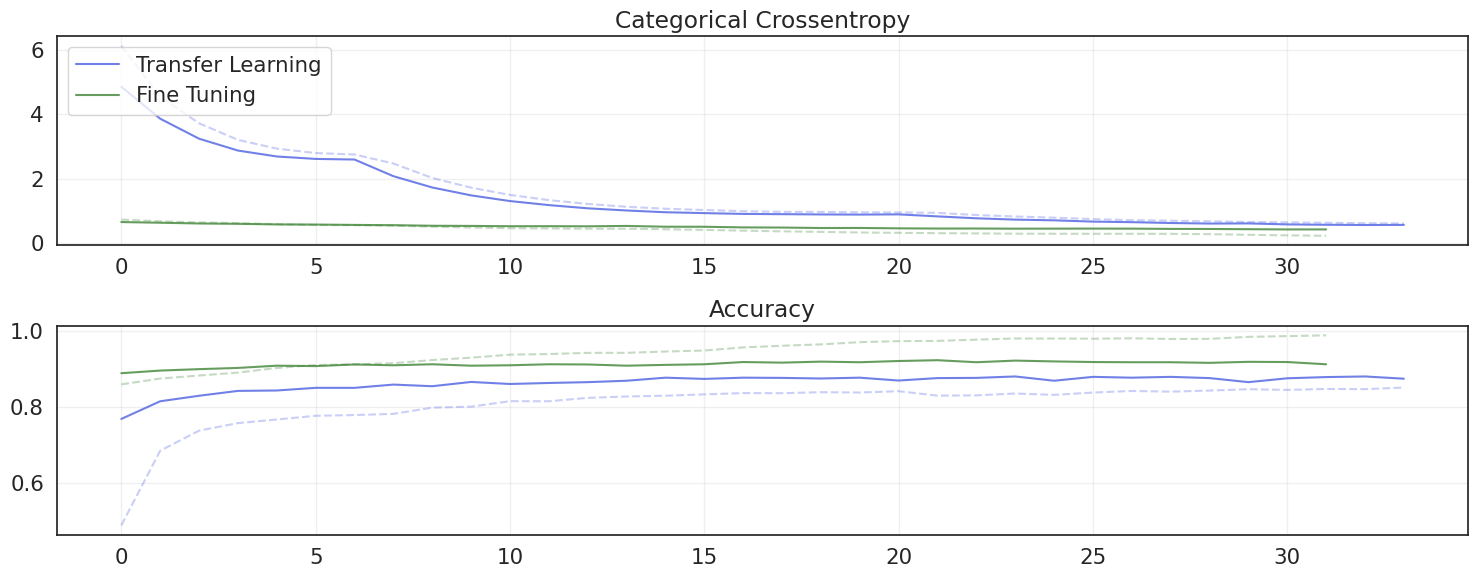

In [ ]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

# 🕹️ Test the Model

In [ ]:
del model
gc.collect()

model = tfk.models.load_model(FT_MODEL_FILENAME)

(1864,)
1
Accuracy score over the test set: 0.9598
Precision score over the test set: 0.96
Recall score over the test set: 0.9598
F1 score over the test set: 0.9595


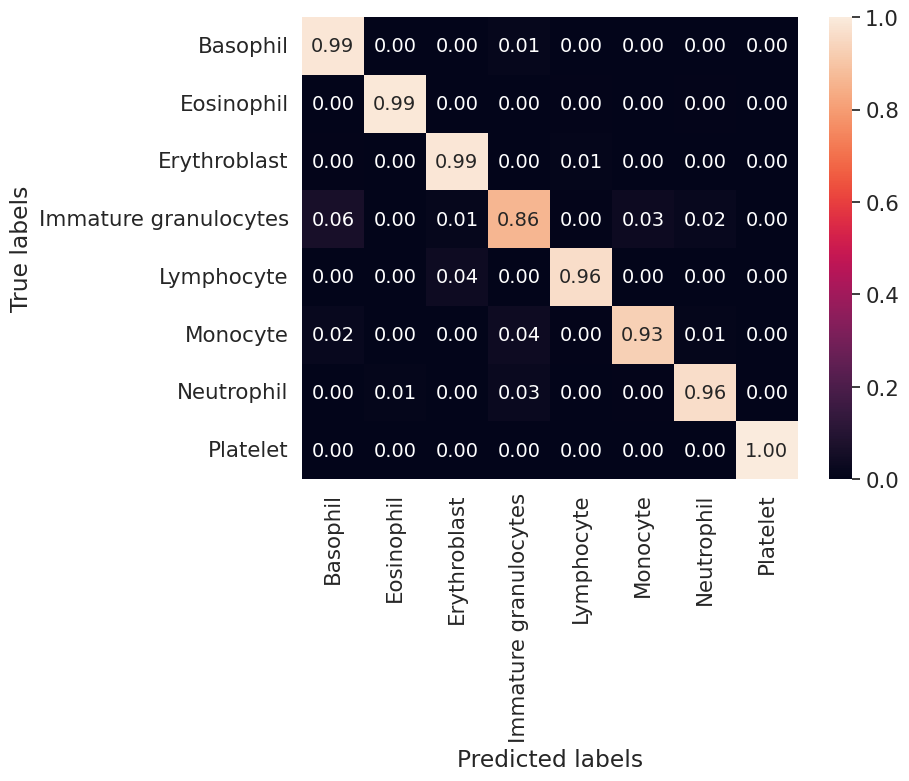

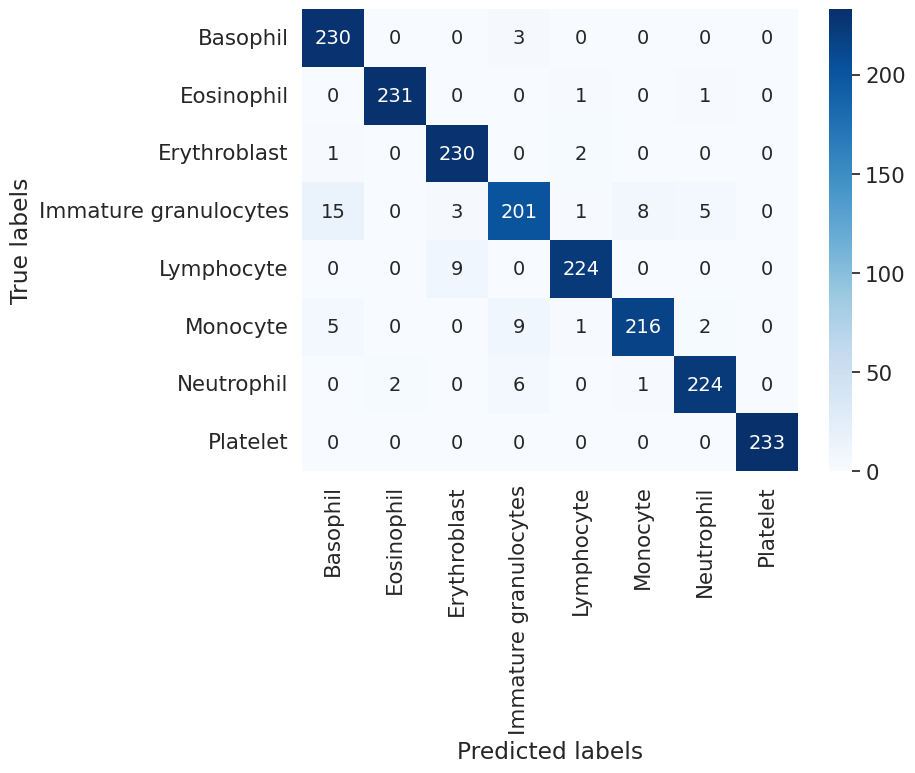

In [ ]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
print(test_predictions.shape)
print(len(test_predictions.shape))

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)
cm_rel = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rel, xticklabels=TEXT_LABELS, yticklabels=TEXT_LABELS, annot=True, fmt='.2f')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=TEXT_LABELS, yticklabels=TEXT_LABELS, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('convnext_ft.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py convnext_ft.keras

  adding: model.py (deflated 55%)
  adding: convnext_ft.keras (deflated 7%)
